In [1]:
%pip install git+https://github.com/patrolSU2019/bbrl_gym.git

  Cloning https://github.com/patrolSU2019/bbrl_gym.git to c:\users\29530\appdata\local\temp\pip-req-build-813sdhj2
  Resolved https://github.com/patrolSU2019/bbrl_gym.git to commit 97e14fe616b2b534879e4b9371ff0c27f3681e6a
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Cloning https://github.com/patrolSU2019/SimpleMazeMDP.git (to revision master) to c:\users\29530\appdata\local\temp\pip-install-kax1ov8z\mazemdp_7a3d2851e93340ed866e8578390ef868
  Resolved https://github.com/patrolSU2019/SimpleMazeMDP.git to commit 32a8f6166d77ce06dc2bf246efd6dc248da40990
  Installing build dependencies: started
  Install

  Running command git clone --filter=blob:none --quiet https://github.com/patrolSU2019/bbrl_gym.git 'C:\Users\29530\AppData\Local\Temp\pip-req-build-813sdhj2'
  Running command git clone --filter=blob:none --quiet https://github.com/patrolSU2019/SimpleMazeMDP.git 'C:\Users\29530\AppData\Local\Temp\pip-install-kax1ov8z\mazemdp_7a3d2851e93340ed866e8578390ef868'

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import os
from typing import Tuple, List

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from mazemdp.toolbox import egreedy, egreedy_loc, softmax, sample_categorical
from mazemdp.maze_plotter import show_videos
from mazemdp.mdp import Mdp
from bbrl_gym.envs.maze_mdp import MazeMDPEnv

# For visualization
os.environ["VIDEO_FPS"] = "5"
if not os.path.isdir("./videos"):
    os.mkdir("./videos")

from IPython.display import Video

# Settings
NB_EPISODES = 50
TIMEOUT = 25


import gym
import bbrl_gym


env = gym.make("MazeMDP-v0", kwargs={"width": 3, "height": 3, "ratio": 0.2})
env.reset()

# set this False to render correctly in pycharm
# env.mdp.plotter.using_notebook = False

# in dynamic programming, there is no agent moving in the environment
env.init_draw("The maze")

Matplotlib backend: module://matplotlib_inline.backend_inline


Output()

In [5]:
# --------------------------- Q-Learning epsilon-greedy version -------------------------------#

# Given an exploration rate epsilon, the QLearning algorithm computes the state action-value function
# based on an epsilon-greedy policy
# alpha is the learning rate

def get_policy_from_q(q: np.ndarray) -> np.ndarray:
    return np.argmax(q, axis=2)
    
def q_learning_eps(
    mdp: MazeMDPEnv,
    epsilon: float,
    nb_episodes: int = 20,
    timeout: int = 50,
    alpha: float = 0.5,
    render: bool = True,
) -> Tuple[np.ndarray, List[float], List[int]]:
    # Initialize the state-action value function
    # alpha is the learning rate
    q = np.zeros((mdp.nb_states, mdp.nb_states -1 ,mdp.action_space.n))
    q_list = []
    time_list = []
        
    # Run learning cycle
    mdp.set_timeout(timeout)  # episode length

    

    if render:
        mdp.init_draw(f"Q-learning e-greedy with goal")
    for goal in range(mdp.nb_states-1):
        mdp.change_last_states([goal])
        for _ in tqdm(range(nb_episodes)):
            # Draw the first state of episode i using a uniform distribution over all the states
            x = mdp.reset(uniform=True)
            done = False
        
            while not done:
                if render:
                    # Show the agent in the maze
                    mdp.draw_v_pi(q[:, goal, : ], np.argmax(q[:, goal, :], axis=1))


                # Draw an action using an epsilon-greedy policy
                u = egreedy(q[:, goal, : ], x, epsilon)

                # Perform a step of the MDP
                [y, r, done, _] = mdp.step(u)
                # Update the state-action value function
                delta = r + mdp.gamma * np.max(q[y, goal]) - q[x,goal,u]
                q[x,goal, u] = q[x,goal, u] + alpha * delta

                # Update the agent position
                x = y
  
            q_list.append(np.linalg.norm(q))
            time_list.append(mdp.mdp.timestep)
    # if render:
    #     # Show the final policy
    #     mdp.current_state = 0
    #     mdp.draw_v_pi(q, get_policy_from_q(q), title="Q-learning e-greedy")
    return q, q_list, time_list


In [3]:
q , q_list, time_list = q_learning_eps(env, 0.1, 20, 20, 0.5, True)

Output()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [9]:
import collections


class ReplayBuffer:
    def __init__(self, max_size: int = 1000):
        self.max_size = max_size
        self.buffer = collections.deque(maxlen=max_size)

    def add(self, experience: Tuple):
        if len(self.buffer) >= self.max_size:
            self.buffer.popleft()
        self.buffer.append(experience)
    
    def size(self):
        return len(self.buffer)
    
    def sample(self, batch_size: int) -> Tuple:
        buffer_flat = np.array(self.buffer).reshape(-1, 6)  # convert buffer to 2D array
        indices = np.random.choice(len(buffer_flat), size=batch_size, replace=False)
        batch = buffer_flat[indices]
        states, actions, rewards, next_states,goals, dones = batch[:, 0], batch[:, 1], batch[:, 2], batch[:, 3], batch[:, 4], batch[:, 5].astype(bool)
        return states, actions, rewards, next_states, goals,dones



    

In [24]:
def q_learning_eps_her(
    mdp: MazeMDPEnv,
    epsilon: float,
    nb_episodes: int = 20,
    timeout: int = 50,
    alpha: float = 0.5,
    render: bool = True,
    batch_size: int = 32,
    replay_buffer_size: int = 1000,
    minibatch_size = 8,
) -> Tuple[np.ndarray, List[float], List[int]]:
    # Initialize the state-action value function
    # alpha is the learning rate
    q = np.zeros((mdp.nb_states, mdp.nb_states -1 ,mdp.action_space.n))
    q_list = []
    time_list = []
    

    replay_buffer = ReplayBuffer(max_size = replay_buffer_size)

    # Run learning cycle
    mdp.set_timeout(timeout)  # episode length

    

    if render:
        mdp.init_draw(f"Q-learning e-greedy with HER and goal")
    for goal in range(mdp.nb_states-1):
        mdp.change_last_states([goal])
        for _ in tqdm(range(nb_episodes)):
            # Draw the first state of episode i using a uniform distribution over all the states
            x = mdp.reset(uniform=True)
            done = False
        
            trajectory = []
            t = 0
            while not done:
                if render:
                    # Show the agent in the maze
                    mdp.draw_v_pi(q[:, goal, : ], np.argmax(q[:, goal, :], axis=1))


                # Draw an action using an epsilon-greedy policy
                u = egreedy(q[:, goal, : ], x, epsilon)

                # Perform a step of the MDP
                [y, r, done, _] = mdp.step(u)
                # Update the state-action value function
                delta = r + mdp.gamma * np.max(q[y, goal]) - q[x,goal,u]
                q[x,goal, u] = q[x,goal, u] + alpha * delta

                # Update the agent position
                x = y
                t += 1
                trajectory.append ([x,u,r,y,goal,done])
                
                # if done:
                #     for k in range(min(minibatch_size,t)):
                #         future_goal = np.random.randint(k, t)
                #         new_goal = trajectory[future_goal][4]
            
                #         for i in range(len(trajectory)):
                #             if trajectory[i][4] == trajectory[future_goal][4]:
                #                 transition = [trajectory[i][0], trajectory[i][1], trajectory[i][2], trajectory[i][3], new_goal, i>=future_goal]
    
                #                 replay_buffer.add(transition)
                if done:
                    
                    for k in range(min(minibatch_size, t)):
                        future_goal = np.random.randint(k, t)
                        new_goal = trajectory[future_goal][4]
                        future_states = [trajectory[i][0] for i in range(future_goal, t)]
                        future_actions = [trajectory[i][1] for i in range(future_goal, t)]
                        future_rewards = [trajectory[i][2] for i in range(future_goal, t)]
                        future_next_states = [trajectory[i][3] for i in range(future_goal, t)]
                        future_dones = [trajectory[i][5] for i in range(future_goal, t)]
                        for i in range(len(future_states)):
                            transition = [future_states[i], future_actions[i], future_rewards[i], future_next_states[i], new_goal, future_dones[i]]
                            replay_buffer.add(transition)

            
            if replay_buffer.size() >= batch_size:
                states, actions, rewards, next_states, goals, dones = replay_buffer.sample(batch_size)

                for i in range(batch_size):
                    xx,uu,rr,yy,goal_new,done_new = states[i].astype(int) , actions[i].astype(int), rewards[i], next_states[i].astype(int), goals[i].astype(int),dones[i]
        
                    delta= rr + mdp.gamma * np.max(q[yy, goal_new]) - q[xx,goal_new,uu]
                    q[xx,goal_new,uu] = q[xx, goal_new,uu] + alpha*delta
            q_list.append(np.linalg.norm(q))
            time_list.append(mdp.mdp.timestep)
            

    # if render:
    #     # Show the final policy
    #     mdp.current_state = 0
    #     mdp.draw_v_pi(q, get_policy_from_q(q), title="Q-learning e-greedy")
    return q, q_list, time_list


In [28]:
q , q_list, time_list = q_learning_eps_her(env, 0.1, 20, 20, 0.5, True)

Output()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [25]:
def plot_ql_3d_goal_inorder(env, epsilon, tau, nb_episodes, timeout, alpha, render):
    q, _, t_list1 = q_learning_eps(env, epsilon, nb_episodes, timeout, alpha, render)
    q, _, t_list2 = q_learning_eps_her(env, epsilon, nb_episodes, timeout, alpha, render)
    plt.figure(figsize=(18,5))
    plt.plot(range(nb_episodes*(env.mdp.nb_states-1)), t_list1, label='q-learning epsilon')
    plt.plot(range(nb_episodes*(env.mdp.nb_states-1)), t_list2, label='q-learning epsilon with her')
    plt.xlabel('Number of episodes')
    plt.ylabel('Number of steps to reach the goal')
    plt.legend(loc='upper right')
    plt.title("Comparison of Time to reach the goal")
    plt.show()

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

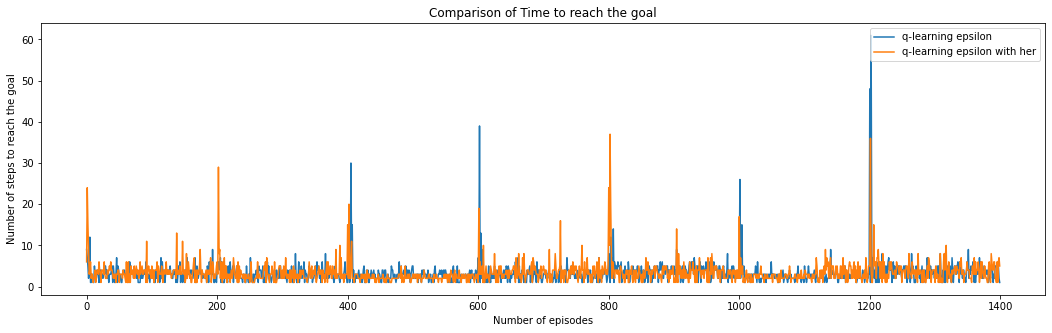

In [26]:
plot_ql_3d_goal_inorder(env, 0.1, 0.1, 200, 75, 0.5, False)